# Compare Qiskit Simulators with different simulation methods

This notebook is a tutorial on how to use different simulator backends to solve the same problem and compare their simulation results. This tutorial compares the performance of a perfect noise-free statvector simulator, a noise-free shot-based simulator, and finally a noisy simulator emulating a real QPU. This notebook uses qiskit simulators for each of the three categories. We employ:
- `qiskit.statevector_simulator`
- noise-free `qiskit.qasm_simulator`
- noisy `qiskit.qasm_simulator` with a real device noise profile

## Begin by importing necessary modules

In [1]:
#some regular python libraries
import networkx as nx
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

#import problem classes from OQ for easy problem creation
from openqaoa.problems.problem import MaximumCut, NumberPartition

#import the QAOA workflow model
from openqaoa.workflows.optimizer import QAOA

#import method to specify the device
from openqaoa.devices import create_device

## Create a problem instance
We begin by creating a problem instance for a simple MaximumCut problem for a random graph created using the python `networkx` module. 

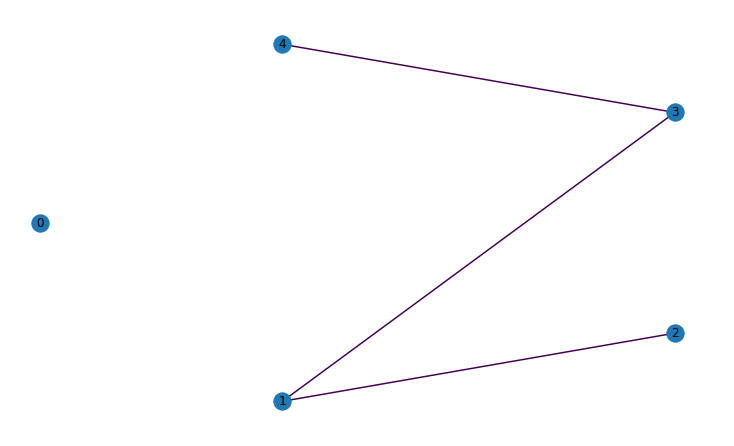

In [2]:
nodes = 5
edge_probability = 0.5
g = nx.generators.fast_gnp_random_graph(n=nodes,p=edge_probability)

# import graph plotter from openqaoa
from openqaoa.utilities import plot_graph
plot_graph(g)

In [3]:
# Use the MaximumCut class to instantiate the problem.
maxcut_prob = MaximumCut(g)

# The method `get_qubo_problem()` translates the problem into a binary Qubo problem. 
# The binary values can be access via the `asdict()` method.
maxcut_qubo = maxcut_prob.get_qubo_problem()

#### Extract the exact solution for a small enough problem



In [4]:
hamiltonian = maxcut_qubo.hamiltonian

# import the brute-force solver to obtain exact solution
from openqaoa.utilities import ground_state_hamiltonian
energy, configuration = ground_state_hamiltonian(hamiltonian)
print(f"Ground State energy: {energy}, Solution: {configuration}")

Qubits in the specified Hamiltonian are remapped to [0, 1, 2, 3].Please specify the physical quantum register as a qubit layout argument in the backend
Ground State energy: -3.0, Solution: ['0110', '1001']


## QAOA models with different devices

Here we create, three different QAOA models with each of the three devices mentioned above

In [5]:
# initialize model with statevector_simulator
q_sv = QAOA()

# device
qiskit_sv = create_device(location='local', name='qiskit.statevector_simulator')
q_sv.set_device(qiskit_sv)

# circuit properties
q_sv.set_circuit_properties(p=2, param_type='standard', init_type='rand', mixer_hamiltonian='x')

# classical optimizer properties
q_sv.set_classical_optimizer(method='COBYLA', maxiter=200,
                             cost_progress=True, parameter_log=True)

q_sv.compile(maxcut_qubo)

Qubits in the specified Hamiltonian are remapped to [0, 1, 2, 3].Please specify the physical quantum register as a qubit layout argument in the backend


In [ ]:
# initialize model with shot-based simulator
q_shot = QAOA()

# device
qiskit_shot = create_device(location='local', name='qiskit.qasm_simulator')
q_shot.set_device(qiskit_shot)

# circuit properties
q_shot.set_circuit_properties(p=2, param_type='standard', init_type='rand', mixer_hamiltonian='x')

# backend properties
q_shot.set_backend_properties(n_shots = 200)

# classical optimizer properties
q_shot.set_classical_optimizer(method='COBYLA', maxiter=200,
                               cost_progress=True, parameter_log=True)

q_shot.compile(maxcut_qubo)

#### Import a noise-model
Finally, import a noise model from a qiskit QPU to be used for noisy simulation with qiskit simulator.

In [ ]:
from qiskit import Aer
from qiskit.test.mock import FakeVigo
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import QasmSimulator
device_backend = FakeVigo()
device = QasmSimulator.from_backend(device_backend)
noise_model = NoiseModel.from_backend(device)

In [ ]:
# initialize model with noisy shot-based simulator
q_noisy_shot = QAOA()

# device

qiskit_noisy_shot = create_device(location='local', name='qiskit.qasm_simulator')
q_noisy_shot.set_device(qiskit_noisy_shot)

# circuit properties
q_noisy_shot.set_circuit_properties(p=2, param_type='standard', init_type='rand', mixer_hamiltonian='x')

# backend properties
q_noisy_shot.set_backend_properties(n_shots = 200, noise_model = noise_model)

# classical optimizer properties
q_noisy_shot.set_classical_optimizer(method='COBYLA', maxiter=200,
                                     cost_progress=True, parameter_log=True)

q_noisy_shot.compile(maxcut_qubo)

## Optimization

Once the models are compiled, we can begin the optimization process. We optimize the problem with all three backends and then plot the results for comparison.

In [ ]:
q_sv.optimize()

In [ ]:
q_shot.optimize()

In [ ]:
q_noisy_shot.optimize()

## Results

In [ ]:
results_sv = q_sv.results
results_shot = q_shot.results
results_noisy_shot = q_noisy_shot.results

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,8))

results_sv.plot_cost(ax=ax,label='Statevector Simulator')
results_shot.plot_cost(ax=ax,color='teal', label='Noise-free shot simulator with 500 shots')
results_noisy_shot.plot_cost(ax=ax,color='green', label='Noisy shot simulator with 500 shots and noise model from ibmq_manila')